In [1]:
# # Do not forget to check if your notebook log collection plugin is working
from mining_extension import check_logging
check_logging("http://3.249.245.244:9999")

Request successful!


# Data Engineering

In [5]:
!unzip data/task1/jetnet_logs.zip

Archive:  data/task1/jetnet_logs.zip
  inflating: jetnet_logs.txt         


In [189]:
import pandas as pd
import re
from datetime import datetime



with open("jetnet_logs.txt", "r") as file:
    content = file.read()

lines = content.split('\n')
user_ids, session_nums, action_times, action_names = [], [], [], []

session_num = 0
for line in lines:
    if not line:
        continue
    session_num += 1
    user_id = re.findall(r"@User(\d+):", line)[0]
    actions = re.findall(r"(?:Action_\d+|END|null)(?: \((?:\d{2}/\d{2}/\d{2} ?\| ?\d{2}:\d{2}:\d{2}|null)\))?",
                         line)
    
    for action in actions:
        action_info = action.split(" ")
        action_name = action_info[0]
        if action_name == 'null':
            action_name = None
        action_time = re.findall(r"\(?(\d{2}/\d{2}/\d{2} ?\| ?\d{2}:\d{2}:\d{2}|null)\)?", action)
        
        if action_time and action_time[0] != 'null' and len(action_time) != 2:
            action_time = datetime.strptime(action_time[0], "%d/%m/%y | %H:%M:%S")
        elif len(action_time) == 2 and action_time[1] != 'null':
            action_time = datetime.strptime(action_time[1], "%d/%m/%y | %H:%M:%S")
        else:
            action_time = None

        user_ids.append(user_id)
        session_nums.append(session_num)
        action_times.append(action_time)
        action_names.append(action_name)

df = pd.DataFrame({
    "user_id": user_ids,
    "session_num": session_nums,
    "action_time": action_times,
    "action_name": action_names
})

first_action_times = df.groupby(['user_id', 'session_num'])['action_time'].min().reset_index()
first_action_times.sort_values(['action_time'], inplace=True)
first_action_times['session_num_sorted'] = range(first_action_times.shape[0])
df = df.merge(first_action_times[['user_id', 'session_num', 'session_num_sorted']],
              on=['user_id', 'session_num'], how='left')
df.drop('session_num', axis=1, inplace=True)
df.rename(columns={'session_num_sorted': 'session_num'}, inplace=True)

assert len(df['session_num'].unique()) == df['session_num'].unique().max() + 1

df

,user_id,action_time,action_name,session_num
0,92,2019-10-15 18:08:02,Action_3,3021
1,92,2019-10-15 18:54:49,Action_1,3021
2,92,2019-10-15 20:02:54,Action_10,3021
3,92,2019-10-15 20:26:56,Action_7,3021
4,92,2019-10-15 20:51:09,Action_0,3021
...,...,...,...,...
2053706,112,2021-07-08 03:18:55,END,78296
2053707,76,2021-07-28 14:35:47,Action_7,80795
2053708,76,2021-07-28 15:09:53,Action_9,80795
2053709,76,2021-07-28 14:59:10,Action_1,80795


In [192]:
df.isna().sum()

user_id           0
action_time    4604
action_name    1060
session_num       0
dtype: int64

In [193]:
df['action_name'].unique()

array(['Action_3', 'Action_1', 'Action_10', 'Action_7', 'Action_0',
       'Action_4', 'Action_8', 'Action_5', 'Action_9', 'END', 'Action_6',
       'Action_2', None], dtype=object)

In [194]:
df.to_csv('all_data.csv', index=False)

In [226]:
df = pd.read_csv('all_data.csv')
df

,user_id,action_time,action_name,session_num
0,92,2019-10-15 18:08:02,Action_3,3021
1,92,2019-10-15 18:54:49,Action_1,3021
2,92,2019-10-15 20:02:54,Action_10,3021
3,92,2019-10-15 20:26:56,Action_7,3021
4,92,2019-10-15 20:51:09,Action_0,3021
...,...,...,...,...
2053706,112,2021-07-08 03:18:55,END,78296
2053707,76,2021-07-28 14:35:47,Action_7,80795
2053708,76,2021-07-28 15:09:53,Action_9,80795
2053709,76,2021-07-28 14:59:10,Action_1,80795


## Drop "end" actions

In [227]:
# df = df[(df['action_name'].notnull()) & (df['action_name'] != 'END')]
df = df[(df['action_name'] != 'END')]
df

,user_id,action_time,action_name,session_num
0,92,2019-10-15 18:08:02,Action_3,3021
1,92,2019-10-15 18:54:49,Action_1,3021
2,92,2019-10-15 20:02:54,Action_10,3021
3,92,2019-10-15 20:26:56,Action_7,3021
4,92,2019-10-15 20:51:09,Action_0,3021
...,...,...,...,...
2053704,112,2021-07-08 02:39:04,Action_9,78296
2053705,112,2021-07-08 02:58:21,Action_3,78296
2053707,76,2021-07-28 14:35:47,Action_7,80795
2053708,76,2021-07-28 15:09:53,Action_9,80795


In [216]:
df['action_name'].unique()

array(['Action_3', 'Action_1', 'Action_10', 'Action_7', 'Action_0',
       'Action_4', 'Action_8', 'Action_5', 'Action_9', 'Action_6',
       'Action_2', nan], dtype=object)

# Metrics Evaluation

In [217]:
df

,user_id,action_time,action_name,session_num
0,92,2019-10-15 18:08:02,Action_3,3021
1,92,2019-10-15 18:54:49,Action_1,3021
2,92,2019-10-15 20:02:54,Action_10,3021
3,92,2019-10-15 20:26:56,Action_7,3021
4,92,2019-10-15 20:51:09,Action_0,3021
...,...,...,...,...
2053704,112,2021-07-08 02:39:04,Action_9,78296
2053705,112,2021-07-08 02:58:21,Action_3,78296
2053707,76,2021-07-28 14:35:47,Action_7,80795
2053708,76,2021-07-28 15:09:53,Action_9,80795


## Mean actions count per user overall

In [218]:
print("Mean actions count per user overall = {:.3f}".format(df.groupby('user_id')['action_time'].count().mean()))

Mean actions count per user overall = 13780.084


## Mean actions by user in a day

In [228]:
df2 = df.copy()
df2

,user_id,action_time,action_name,session_num
0,92,2019-10-15 18:08:02,Action_3,3021
1,92,2019-10-15 18:54:49,Action_1,3021
2,92,2019-10-15 20:02:54,Action_10,3021
3,92,2019-10-15 20:26:56,Action_7,3021
4,92,2019-10-15 20:51:09,Action_0,3021
...,...,...,...,...
2053704,112,2021-07-08 02:39:04,Action_9,78296
2053705,112,2021-07-08 02:58:21,Action_3,78296
2053707,76,2021-07-28 14:35:47,Action_7,80795
2053708,76,2021-07-28 15:09:53,Action_9,80795


In [229]:
df[df['action_time'].isna()]

,user_id,action_time,action_name,session_num
1733,83,NaN,Action_3,53413
1797,38,NaN,Action_7,66604
2451,4,NaN,Action_3,70063
3959,119,NaN,Action_8,56973
4253,122,NaN,Action_6,12577
...,...,...,...,...
2051483,94,NaN,Action_0,64510
2051814,112,NaN,Action_10,2104
2051997,20,NaN,Action_6,17902
2052392,33,NaN,Action_7,79944


**Let's say if we have None in action_time, but we know that previous and next sessions was the same (in the sorted by session_num and action_time table); and they have the same date - we can assume this value with the same date**

In [230]:
df2 = df2.sort_values(by=['session_num', 'action_time'])
df2

,user_id,action_time,action_name,session_num
957131,122,2019-09-20 13:44:16,Action_7,0
759183,103,2019-09-20 13:45:07,Action_7,1
759185,103,2019-09-20 14:27:15,Action_4,1
759186,103,2019-09-20 14:27:19,Action_4,1
759184,103,2019-09-20 14:28:28,Action_7,1
...,...,...,...,...
462320,126,2021-09-19 07:53:42,Action_8,87082
462321,126,2021-09-19 08:08:16,Action_3,87082
462322,126,2021-09-19 08:47:05,Action_4,87082
462323,126,2021-09-19 09:11:52,Action_10,87082


In [221]:
def assume_date(row, df):
    index = row.name
    if pd.isnull(row['action_time']):
        if (index > 0) and (index < len(df) - 1):
            prev_row = df.iloc[index - 1]
            next_row = df.iloc[index + 1]
            if (row['session_num'] == prev_row['session_num'] == next_row['session_num']) and (prev_row['action_time'].date() == next_row['action_time'].date()):
                return prev_row['action_time'].date()
    return row['action_time']

In [236]:
df2['action_time'] = df2.apply(lambda row: assume_date(row, df2), axis=1)
df2[df2['action_time'].isna()].shape

(4428, 4)

Useless ;)

In [253]:
df2 = df2.dropna(subset=['action_time'])
df2['action_time'] = pd.to_datetime(df2['action_time'])
df2['date'] = df2['action_time'].dt.date
actions_by_user_in_day = df2.groupby(['user_id', 'date'])['action_name'].count().reset_index(name='action_count')
mean_actions_by_user_in_day = actions_by_user_in_day.groupby('user_id')['action_count'].mean()\
                                .reset_index(name='Mean_actions_in_day')
mean_actions_by_user_in_day.to_csv('mean_actions_by_user_in_day.csv', index=False)
mean_actions_by_user_in_day

,user_id,Mean_actions_in_day
0,0,23.152778
1,1,40.157971
2,2,33.359055
3,3,29.846527
4,4,15.461832
...,...,...
138,138,20.875776
139,139,40.406433
140,140,35.775362
141,141,19.157107


# The probability of repeating the same action three times in a row during one session

In [280]:
def is_there_triple(series):
    for i in range(len(series) - 2):
        if series.iloc[i] == series.iloc[i + 1] == series.iloc[i + 2]:
            return 1
    return 0


triple_counts = df.groupby('session_num')['action_name'].apply(is_there_triple).reset_index(name='triple_counts')

print('Probability of repeating the same action three times in a row during one session is {:.3f}'\
      .format(triple_counts['triple_counts'].sum() / triple_counts.shape[0]))

Probability of repeating the same action three times in a row during one session is 0.326


# The 0.95 quantile of distribution of time delta between the actions of the same type distribution during one session

In [295]:
df2 = df.copy()
df2 = df2.dropna(subset=['action_time'])
df2['action_time'] = pd.to_datetime(df2['action_time'])

df2['time_delta'] = df2.groupby(by=['session_num', 'action_name'])['action_time'].diff()
df2 = df2.dropna(subset=['time_delta'])
quant_95 = df2['time_delta'].quantile(0.95)

print('0.95 quantile =', quant_95)

0.95 quantile = 0 days 07:41:31


# Is there statistical difference of activity in different days of the week? And between weekends and workdays

In [298]:
df2 = df.copy()
df2 = df2.dropna(subset=['action_time'])
df2['action_time'] = pd.to_datetime(df2['action_time'])
df

,user_id,action_time,action_name,session_num
0,92,2019-10-15 18:08:02,Action_3,3021
1,92,2019-10-15 18:54:49,Action_1,3021
2,92,2019-10-15 20:02:54,Action_10,3021
3,92,2019-10-15 20:26:56,Action_7,3021
4,92,2019-10-15 20:51:09,Action_0,3021
...,...,...,...,...
2053704,112,2021-07-08 02:39:04,Action_9,78296
2053705,112,2021-07-08 02:58:21,Action_3,78296
2053707,76,2021-07-28 14:35:47,Action_7,80795
2053708,76,2021-07-28 15:09:53,Action_9,80795


In [300]:
df2['week_day'] = df2['action_time'].dt.day_name()
df2['is_weekend'] = df2['week_day'].apply(lambda x: 'weekend' if x in ['Saturday', 'Sunday'] else 'workday')
df2

,user_id,action_time,action_name,session_num,week_day,is_weekend
0,92,2019-10-15 18:08:02,Action_3,3021,Tuesday,workday
1,92,2019-10-15 18:54:49,Action_1,3021,Tuesday,workday
2,92,2019-10-15 20:02:54,Action_10,3021,Tuesday,workday
3,92,2019-10-15 20:26:56,Action_7,3021,Tuesday,workday
4,92,2019-10-15 20:51:09,Action_0,3021,Tuesday,workday
...,...,...,...,...,...,...
2053704,112,2021-07-08 02:39:04,Action_9,78296,Thursday,workday
2053705,112,2021-07-08 02:58:21,Action_3,78296,Thursday,workday
2053707,76,2021-07-28 14:35:47,Action_7,80795,Wednesday,workday
2053708,76,2021-07-28 15:09:53,Action_9,80795,Wednesday,workday


In [303]:
actions_by_day_mean = df2.groupby('week_day')['action_name'].count()
actions_by_day

week_day
Friday       281844
Monday       276021
Saturday     284392
Sunday       283277
Thursday     280182
Tuesday      280870
Wednesday    282908
Name: action_name, dtype: int64

In [304]:
actions_by_weekend = df2.groupby('is_weekend')['action_name'].count()
actions_by_weekend

is_weekend
weekend     567669
workday    1401825
Name: action_name, dtype: int64

**So. If we talk only about days of the week, we have only 7 numbers of num activities per day. Statistical tests are useles in this situatuons, but we can look at histograms and on the difference from mean**

In [309]:
df2['date'] = df2['action_time'].dt.date
df2

,user_id,action_time,action_name,session_num,week_day,is_weekend,day,date
0,92,2019-10-15 18:08:02,Action_3,3021,Tuesday,workday,15,2019-10-15
1,92,2019-10-15 18:54:49,Action_1,3021,Tuesday,workday,15,2019-10-15
2,92,2019-10-15 20:02:54,Action_10,3021,Tuesday,workday,15,2019-10-15
3,92,2019-10-15 20:26:56,Action_7,3021,Tuesday,workday,15,2019-10-15
4,92,2019-10-15 20:51:09,Action_0,3021,Tuesday,workday,15,2019-10-15
...,...,...,...,...,...,...,...,...
2053704,112,2021-07-08 02:39:04,Action_9,78296,Thursday,workday,8,2021-07-08
2053705,112,2021-07-08 02:58:21,Action_3,78296,Thursday,workday,8,2021-07-08
2053707,76,2021-07-28 14:35:47,Action_7,80795,Wednesday,workday,28,2021-07-28
2053708,76,2021-07-28 15:09:53,Action_9,80795,Wednesday,workday,28,2021-07-28


In [312]:
mean_click_by_day = df2.groupby('date').count()['day'].mean()
mean_click_by_day

2692.0109289617485

In [313]:
df

,user_id,action_time,action_name,session_num
0,92,2019-10-15 18:08:02,Action_3,3021
1,92,2019-10-15 18:54:49,Action_1,3021
2,92,2019-10-15 20:02:54,Action_10,3021
3,92,2019-10-15 20:26:56,Action_7,3021
4,92,2019-10-15 20:51:09,Action_0,3021
...,...,...,...,...
2053704,112,2021-07-08 02:39:04,Action_9,78296
2053705,112,2021-07-08 02:58:21,Action_3,78296
2053707,76,2021-07-28 14:35:47,Action_7,80795
2053708,76,2021-07-28 15:09:53,Action_9,80795


**Let's seperate each day on the 24 hours. So we will have 7 different distributions and can perform chi-square test**

In [314]:
df2 = df.copy()
df2 = df2.dropna(subset=['action_time'])
df2['action_time'] = pd.to_datetime(df2['action_time'])
df2['weekday'] = df2['action_time'].dt.weekday
df2['hour'] = df2['action_time'].dt.hour

In [317]:
weekday_hour_counts = df2.groupby(['weekday', 'hour']).size().unstack(fill_value=0)
weekday_hour_counts

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
weekday,,,,,,,,,,,,,,,,,,,,,
0,19041,18805,17495,16282,14814,13384,11662,10321,8869,7306,...,5412,6745,8200,9803,11141,12738,13939,15480,16962,18187
1,19087,19153,17947,16588,15041,13721,11945,10319,8957,7654,...,5580,6731,8566,9956,11364,13106,14085,15657,17056,18244
2,18895,19150,17975,16498,15305,13610,12282,10718,9199,7829,...,5451,6995,8460,9927,11456,13117,14459,16060,16955,18352
3,19015,19151,17807,16481,15011,13609,12162,10600,9223,7824,...,5487,6828,8279,9705,11298,12856,14170,15527,16913,18020
4,19137,19271,18089,16583,15354,13619,12120,10525,9048,7696,...,5382,6843,8388,9891,11463,12904,14417,15743,16876,18405
5,19061,18934,18006,16543,14948,13356,12020,10516,9029,7782,...,5604,7085,8611,10121,11870,13442,14827,16185,17402,18615
6,19644,19806,18347,17150,15470,13923,12623,10505,9010,7892,...,5496,6757,8346,9676,11392,12711,13997,15447,16631,17698


In [320]:
from scipy.stats import chi2_contingency


chi2, p_value, _, _ = chi2_contingency(weekday_hour_counts)

print(f"Chi-square: {chi2}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference between the distributions.")
else:
    print("There is no significant difference between the distributions.")

Chi-square: 362.6617239236543
P-value: 4.290603798992426e-22
There is a significant difference between the distributions.


**and for weekdays**

In [340]:
df2['weekday_name'] = df2['action_time'].dt.day_name()
df2['is_weekend'] = df2['weekday_name'].apply(lambda x: 'weekend' if x in ['Saturday', 'Sunday'] else 'workday')
weekend_hour_counts = df2.groupby(['is_weekend', 'hour']).size().unstack(fill_value=0)
weekend_hour_counts.loc['weekend'] = weekend_hour_counts.loc['weekend'].divide(2)
weekend_hour_counts.loc['workday'] = weekend_hour_counts.loc['workday'].divide(5)
weekend_hour_counts

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
is_weekend,,,,,,,,,,,,,,,,,,,,,
weekend,19352.5,19370,18176.5,16846.5,15209,13639.5,12321.5,10510.5,9019.5,7837.0,...,5550.0,6921.0,8478.5,9898.5,11631.0,13076.5,14412,15816.0,17016.5,18156.5
workday,19035.0,19106,17862.6,16486.4,15105,13588.6,12034.2,10496.6,9059.2,7661.8,...,5462.4,6828.4,8378.6,9856.4,11344.4,12944.2,14214,15693.4,16952.4,18241.6


In [341]:
chi2, p_value, _, _ = chi2_contingency(weekend_hour_counts)

print(f"Chi-square: {chi2}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference between the distributions.")
else:
    print("There is no significant difference between the distributions.")

Chi-square: 14.061947315433724
P-value: 0.9250835744791995
There is no significant difference between the distributions.


## Own metrics

In [346]:
df2 = df.copy()
df2 = df2.dropna(subset=['action_time'])
df2['action_time'] = pd.to_datetime(df2['action_time'])
df2

,user_id,action_time,action_name,session_num
0,92,2019-10-15 18:08:02,Action_3,3021
1,92,2019-10-15 18:54:49,Action_1,3021
2,92,2019-10-15 20:02:54,Action_10,3021
3,92,2019-10-15 20:26:56,Action_7,3021
4,92,2019-10-15 20:51:09,Action_0,3021
...,...,...,...,...
2053704,112,2021-07-08 02:39:04,Action_9,78296
2053705,112,2021-07-08 02:58:21,Action_3,78296
2053707,76,2021-07-28 14:35:47,Action_7,80795
2053708,76,2021-07-28 15:09:53,Action_9,80795


## Firstly, mean duration of the session is important to understand

In [348]:
def session_duration(series):
    return series.max() - series.min()

session_duration = df2.groupby('session_num')['action_time'].apply(session_duration).\
                    reset_index(name='session_duration')
session_duration

,session_num,session_duration
0,0,0 days 00:00:00
1,1,0 days 18:00:45
2,2,0 days 05:12:30
3,3,0 days 01:27:30
4,4,0 days 23:09:12
...,...,...
86025,87078,0 days 02:11:19
86026,87079,0 days 11:10:17
86027,87080,0 days 11:15:32
86028,87081,0 days 08:31:54


In [349]:
session_duration['session_duration'].mean()

Timedelta('1 days 11:26:39.473950947')

**And per user**

In [358]:
df2_sorted = df2.sort_values(by=['user_id', 'session_num', 'action_time'])
session_duration = df2.groupby(['user_id', 'session_num'])['action_time'].apply(lambda x: x.max() - x.min()).\
                    reset_index(name='session_duration')
mean_session_duration = session_duration.groupby('user_id')['session_duration'].mean()
mean_session_duration

user_id
0     0 days 21:42:33.237524950
1     1 days 07:36:22.931380753
2     1 days 23:17:51.101995565
3     3 days 01:05:03.291560102
4     0 days 17:00:58.605555555
                 ...           
138   0 days 10:58:19.118568232
139   0 days 15:28:41.409862570
140   0 days 20:09:40.829379562
141   1 days 12:45:01.718266253
142   1 days 06:47:25.170111287
Name: session_duration, Length: 143, dtype: timedelta64[ns]

## Secondly, num of unique actions per session is also important

In [361]:
df2.groupby('session_num')['action_name'].apply(lambda x: len(set(x))).mean()

7.806683714983145

**And per user**

In [365]:
mean_unique = df2.groupby(['user_id', 'session_num'])['action_name'].apply(lambda x: len(set(x)))
mean_unique.groupby('user_id').mean()

user_id
0      7.898204
1      7.856904
2      7.800443
3      7.939898
4      7.794444
         ...   
138    7.653244
139    7.723525
140    7.691606
141    7.928793
142    7.717011
Name: action_name, Length: 143, dtype: float64

# Data Visualisation

## The time series (line plot) of count of different actions by days

In [367]:
df2 = df.copy()
df2 = df2.dropna(subset=['action_time'])
df2['action_time'] = pd.to_datetime(df2['action_time'])
df2

,user_id,action_time,action_name,session_num
0,92,2019-10-15 18:08:02,Action_3,3021
1,92,2019-10-15 18:54:49,Action_1,3021
2,92,2019-10-15 20:02:54,Action_10,3021
3,92,2019-10-15 20:26:56,Action_7,3021
4,92,2019-10-15 20:51:09,Action_0,3021
...,...,...,...,...
2053704,112,2021-07-08 02:39:04,Action_9,78296
2053705,112,2021-07-08 02:58:21,Action_3,78296
2053707,76,2021-07-28 14:35:47,Action_7,80795
2053708,76,2021-07-28 15:09:53,Action_9,80795


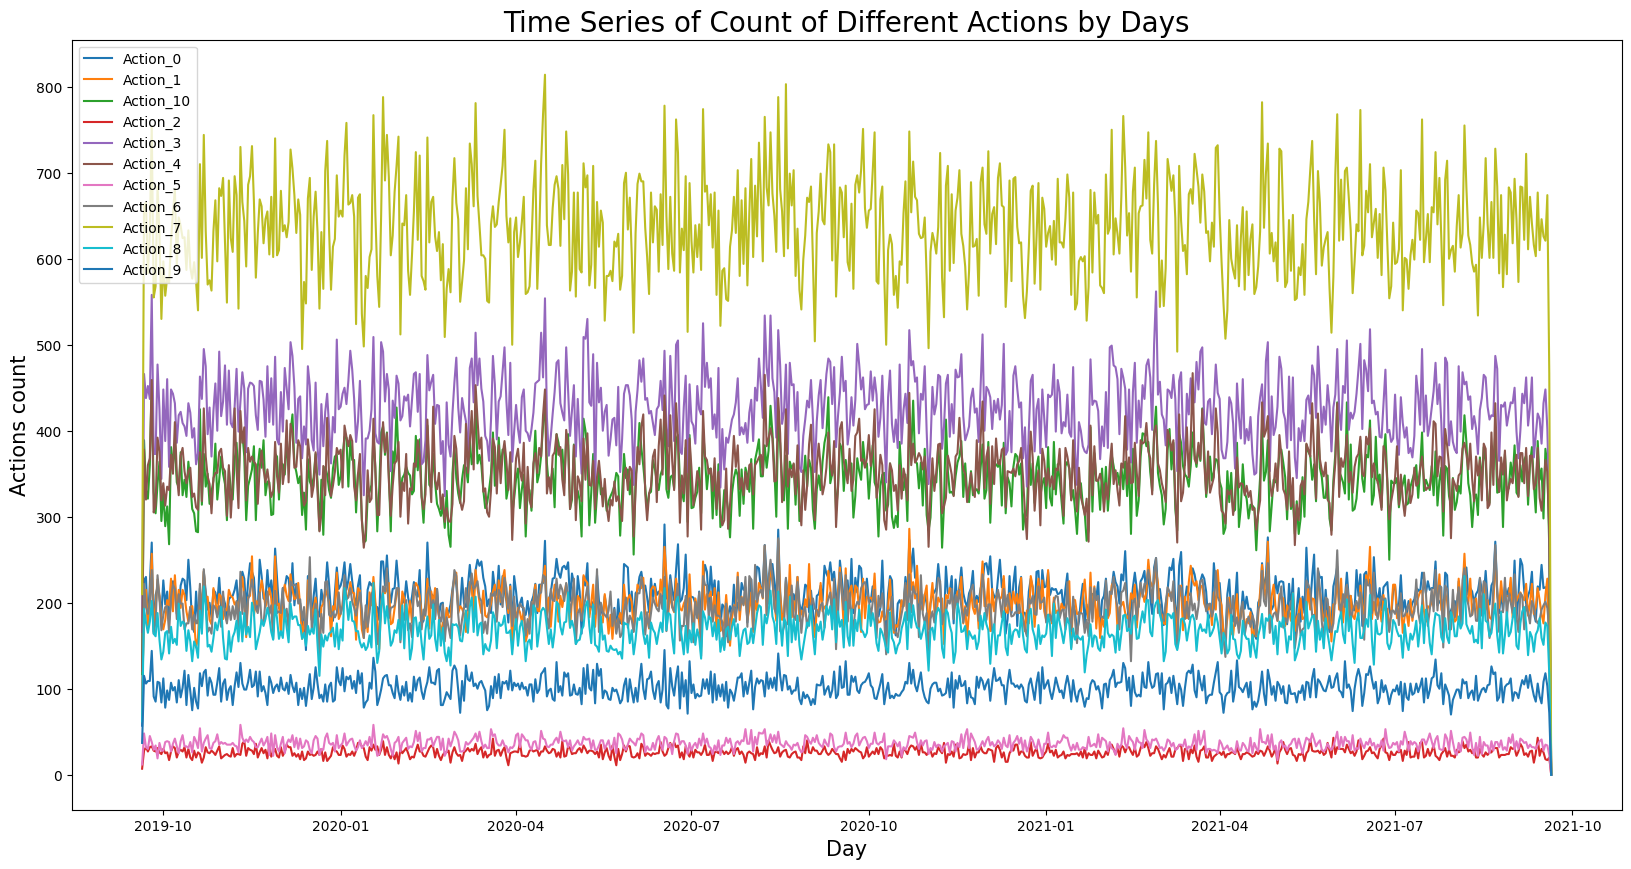

In [376]:
import matplotlib.pyplot as plt


df2['date'] = df2['action_time'].dt.date
action_count_by_day = df2.groupby(['date', 'action_name']).size().reset_index(name='count')
table_draw = action_count_by_day.pivot_table(index='date', columns='action_name', values='count',
                                            fill_value=0)

plt.figure(figsize=(20, 10))
plt.plot(table_draw)
plt.legend(table_draw.columns)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Actions count', fontsize=15)
plt.title('Time Series of Count of Different Actions by Days', fontsize=20)
plt.show()

# The barchart of different actions counts

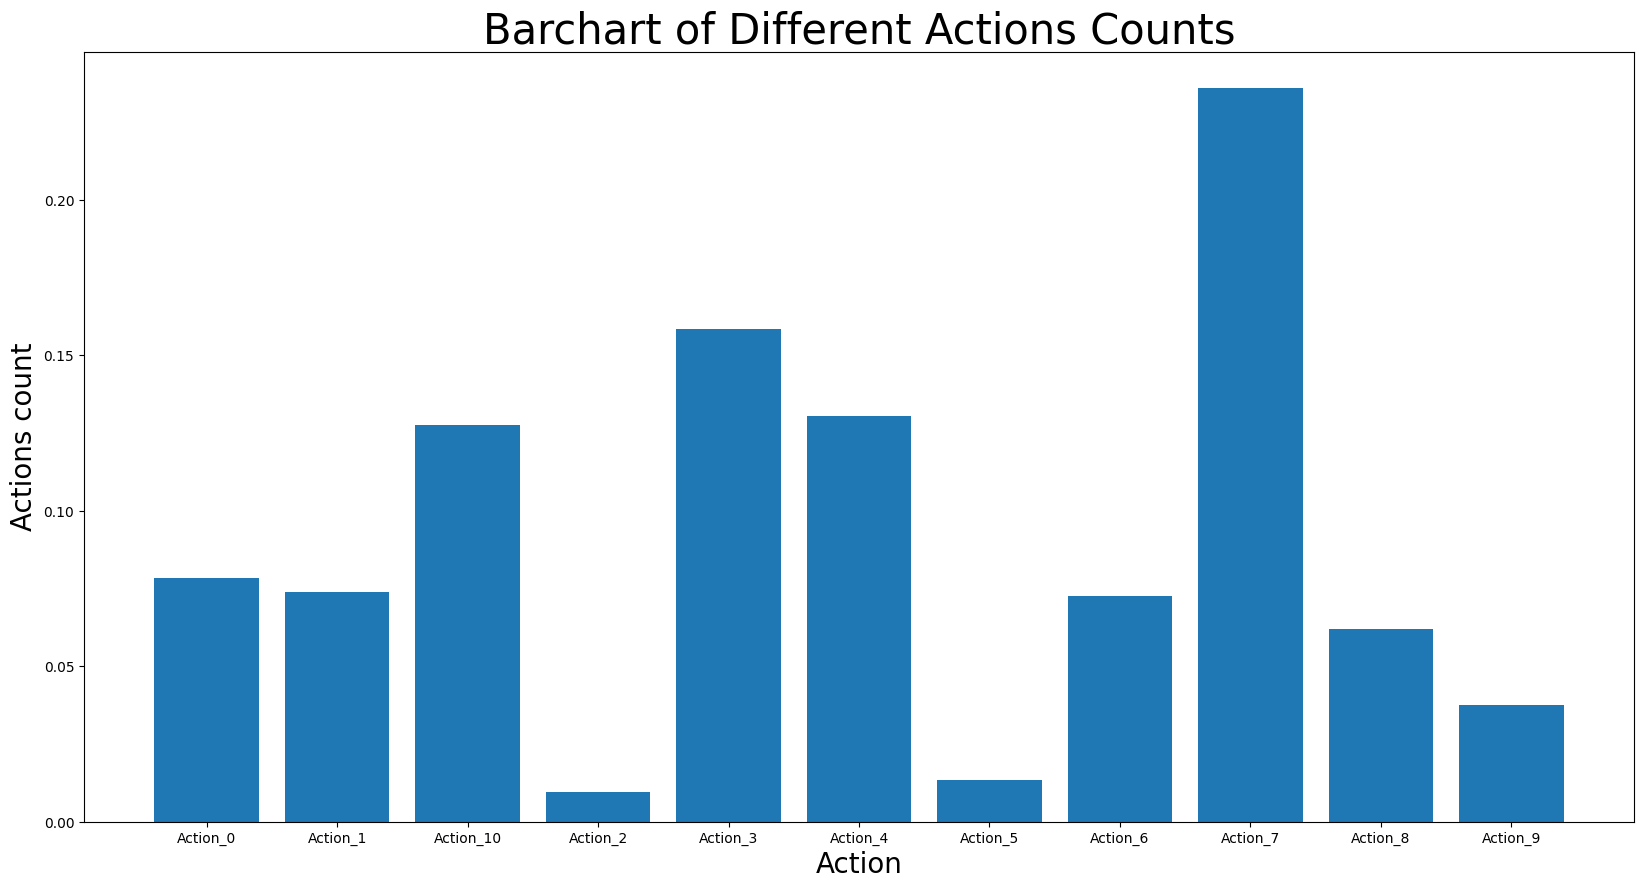

In [394]:
actions_count = df2['action_name'].value_counts(normalize=True).reset_index(name='actions_count').sort_values(by=['action_name'])

plt.figure(figsize=(20, 10))
plt.bar(actions_count['action_name'], actions_count['actions_count'])
plt.xlabel('Action', fontsize=20)
plt.ylabel('Actions count', fontsize=20)
plt.title('Barchart of Different Actions Counts', fontsize=30)
plt.show()

# the heatmap of action_i-action_j-count where count is a count of action_i right after the action_j

In [409]:
df2 = df.copy()
df2 = df2.dropna(subset=['action_time', 'action_name'])
df2['action_time'] = pd.to_datetime(df2['action_time'])
dfff = df.copy()
dfff = dfff.dropna(subset=['action_time', 'action_name'])
dfff['action_time'] = pd.to_datetime(dfff['action_time'])

<Axes: xlabel='action_j', ylabel='action_i'>

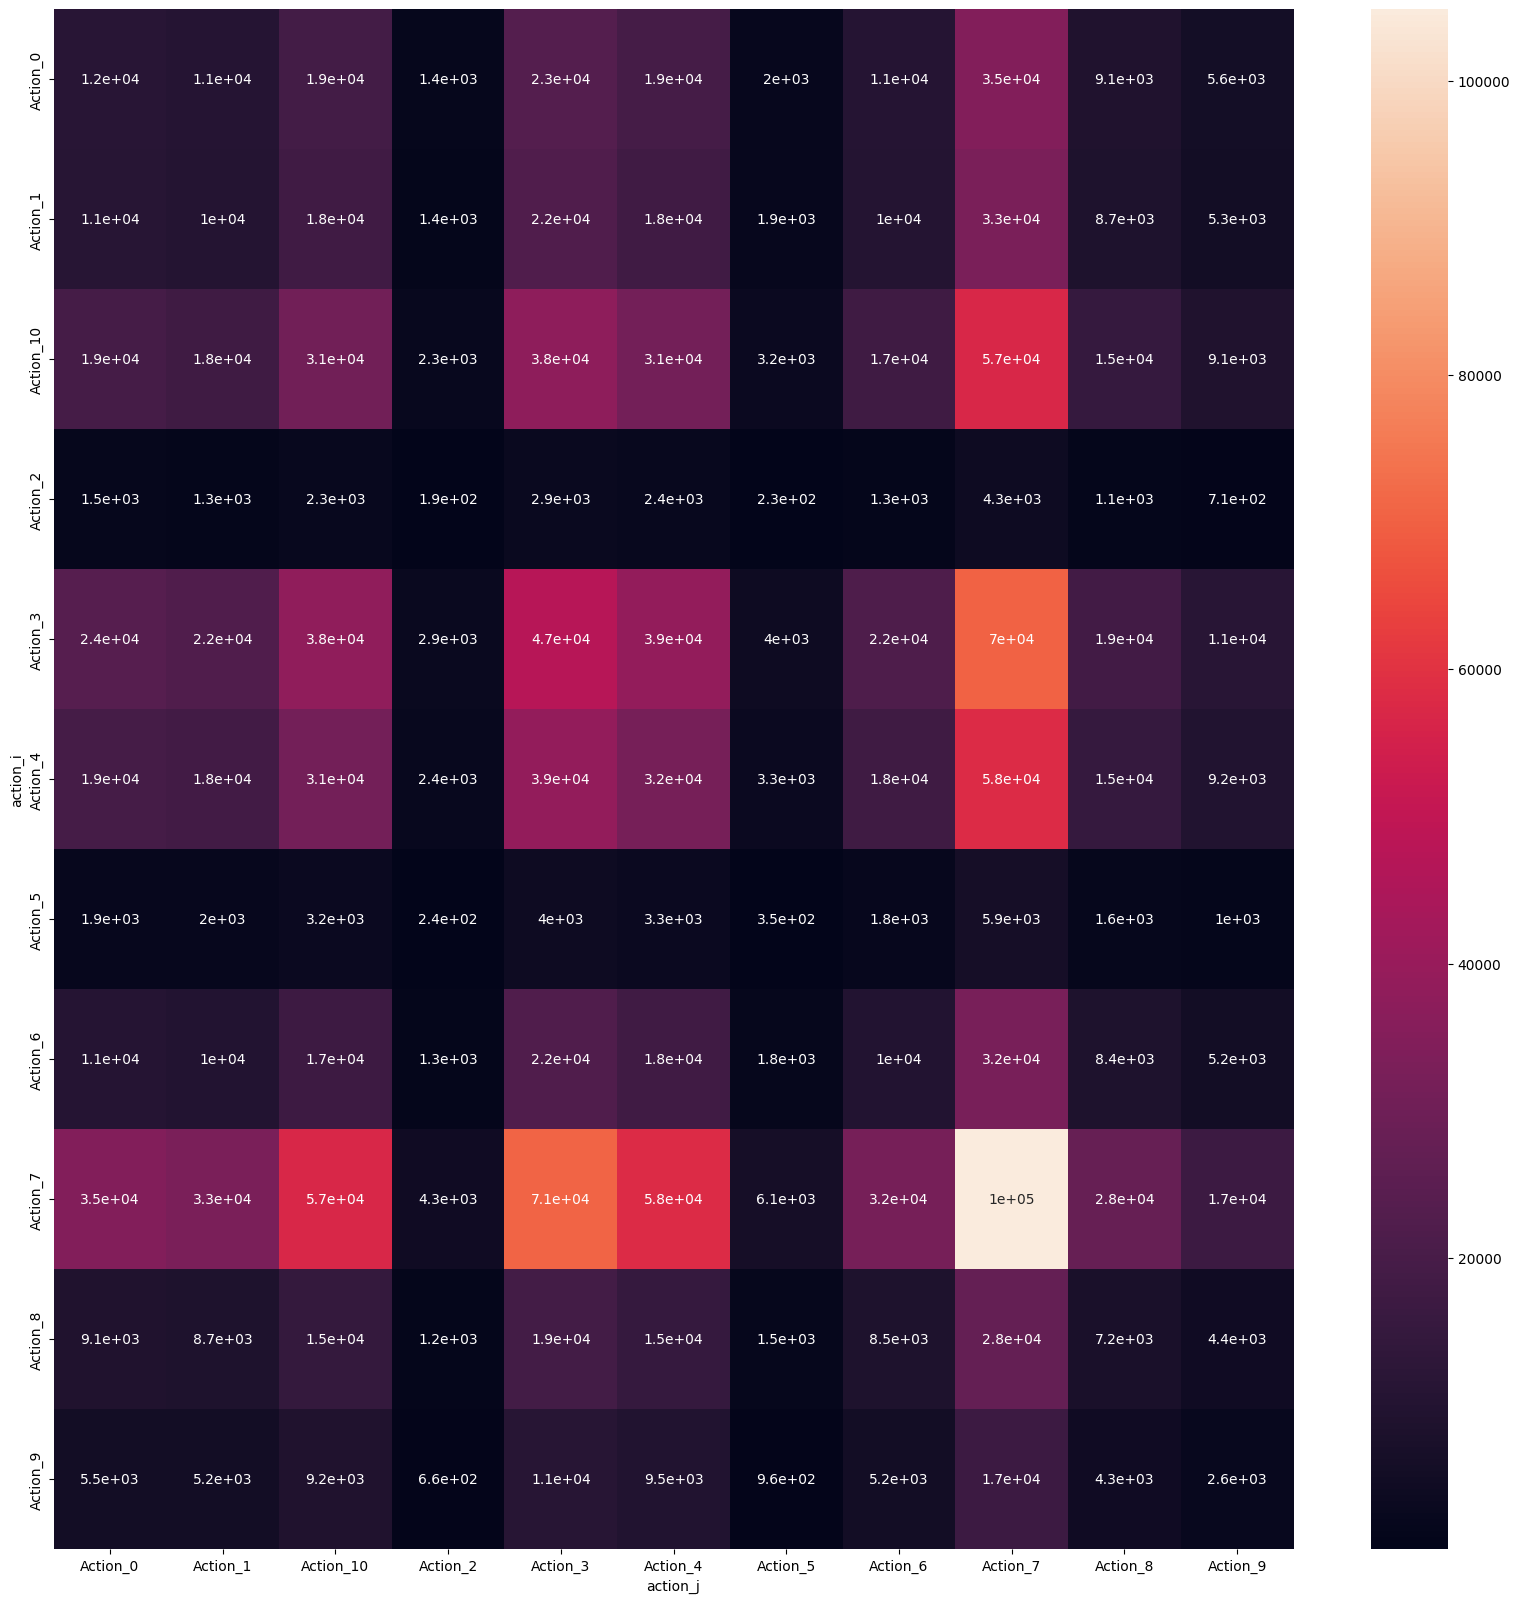

In [410]:
import seaborn as sns


def my_calc(x):
    for i in range(1, len(x)):
        d[(x[i - 1], x[i])] += 1
        
df2 = df2.groupby('session_num')["action_name"].agg(list).reset_index()
uni_actions = sorted(dfff['action_name'].unique())
d = {(x, y): 0 for x in uni_actions for y in uni_actions}

df2["action_name"].apply(my_calc)
df_new = pd.DataFrame.from_dict(d, orient='index', columns=['count'])
df_new[['action_i', 'action_j']] = pd.DataFrame(df_new.index.tolist(), index=df_new.index)

fin = df_new.pivot(index='action_i', columns='action_j', values='count')
plt.figure(figsize=(20, 20))
sns.heatmap(fin, annot=True)

In [406]:
df2['action_name'].unique()

TypeError: unhashable type: 'list'